In [1]:
# Importing the required modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
import pickle
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [3]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'Kadapa']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
995,995,14.83,78.97,Kadapa,B Mattam,Choudaryvaripalli,Black,9.13,1.21,0.27,5.47,242.0,2748.0,660.0,82.19,0.44,4.21,11.56,1.95,13.28,0.237624,0.040050,0.439279,1.189142,-0.372872,Cotton
996,996,14.82,78.97,Kadapa,B Mattam,Choudaryvaripalli,Black,8.86,0.38,0.46,12.12,353.0,3048.0,908.0,15.89,0.45,2.57,11.58,1.49,13.40,0.184751,-0.010253,0.309800,0.966620,-0.325832,Cotton
997,997,14.84,78.97,Kadapa,B Mattam,Choudaryvaripalli,Black,8.75,0.39,0.72,21.41,194.0,3596.0,651.0,19.20,0.58,1.88,27.66,2.47,8.27,0.239087,0.041130,0.441895,1.166667,-0.368421,Cotton
998,998,14.84,78.97,Kadapa,B Mattam,Choudaryvaripalli,Black,9.18,1.08,0.25,6.06,238.0,2823.0,678.0,86.49,0.38,4.56,10.54,1.75,12.32,0.239087,0.041130,0.441895,1.166667,-0.368421,Cotton
999,999,14.82,78.97,Kadapa,B Mattam,Choudaryvaripalli,Black,8.91,0.40,0.46,11.24,340.0,3052.0,906.0,14.79,0.48,2.36,12.82,1.49,13.09,0.184751,-0.010253,0.309800,0.966620,-0.325832,Cotton


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'ARVI', 'EVI', 'GCI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI
count,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000
mean,7.976264,0.612711,0.424806,15.205171,150.066059,1755.362187,399.334852,28.152916,0.770205,1.361025,13.087995,1.412779,13.341868,0.324406
std,0.935555,1.841537,0.228146,12.461093,111.832730,943.677935,248.130562,54.203837,0.657903,1.055433,11.421245,0.768919,8.564551,0.183091
min,4.610000,0.020000,0.020000,0.670000,18.000000,149.000000,30.000000,0.730000,0.100000,0.030000,0.730000,0.310000,1.550000,-0.214357
25%,7.800000,0.100000,0.250000,5.680000,87.500000,873.000000,198.000000,3.560000,0.400000,0.455000,4.730000,0.775000,7.260000,0.223922
50%,8.250000,0.280000,0.370000,12.170000,125.000000,1826.000000,351.000000,10.930000,0.580000,1.200000,9.280000,1.320000,11.930000,0.285888
75%,8.515000,0.685000,0.570000,20.770000,182.000000,2429.000000,556.000000,30.355000,0.945000,1.995000,17.515000,1.840000,17.325000,0.415775
max,9.890000,27.500000,1.500000,86.820000,1317.000000,4813.000000,1293.000000,664.030000,6.050000,7.890000,70.830000,4.520000,68.090000,0.737839


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Black', 'Red', 'Red Sandy', 'Sandy', 'red'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace('Black', 'Black Soil')
df['SoilType'] = df['SoilType'].replace(['red', 'Red'], 'Red Soil')
df['SoilType'] = df['SoilType'].replace('Red Sandy', 'Red Sandy Soil')
df['SoilType'] = df['SoilType'].replace('Sandy', 'Sandy Soil')
df.SoilType.unique()

array(['Black Soil', 'Red Soil', 'Red Sandy Soil', 'Sandy Soil'],
      dtype=object)

In [11]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Soil': 117, 'Red Sandy Soil': 2, 'Red Soil': 315, 'Sandy Soil': 5}

<BarContainer object of 4 artists>

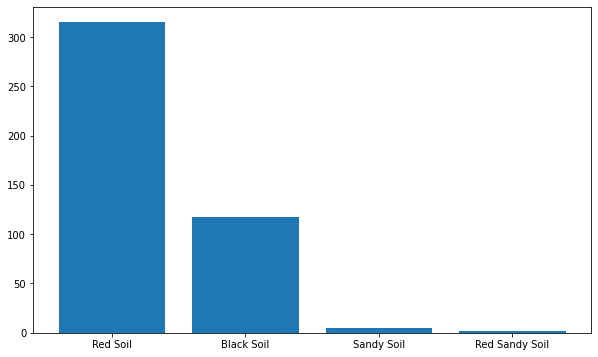

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['Cotton', 'Sunflower', 'Maize', 'Paddy', 'Chilly', 'Mirchi',
       'Bajra', 'Jowar', 'Turmaric', 'Groundnut', 'Redgram', 'Tomato',
       'Light Black', 'Mango', 'Cowpea', 'Horsegram'], dtype=object)

In [15]:
df['Crop'].value_counts()

Groundnut      109
Cotton         108
Paddy           91
Horsegram       30
Sunflower       21
Tomato          19
Mango           19
Bajra           10
Maize            9
Jowar            8
Cowpea           4
Redgram          4
Chilly           3
Turmaric         2
Mirchi           1
Light Black      1
Name: Crop, dtype: int64

GroundNut         109
Cotton            108
Paddy              91
HorseGram          30
Maize + Millet     27
Tomato             19
Mango              19
Name: Crop, dtype: int64


<BarContainer object of 7 artists>

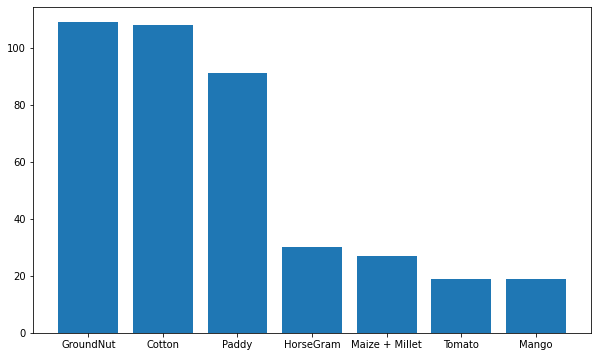

In [16]:
df['Crop'] = df['Crop'].replace('Groundnut', 'GroundNut')
df['Crop'] = df['Crop'].replace('Horsegram', 'HorseGram')
df['Crop'] = df['Crop'].replace(['Jowar', 'Bajra'], 'Millet')
df['Crop'] = df['Crop'].replace(['Maize', 'Millet'], 'Maize + Millet')
df = df[(df['Crop'] != 'Mirchi') & (df['Crop'] != 'Light Black') & (df['Crop'] != 'Turmaric') & (df['Crop'] != 'Chilly') & (df['Crop'] != 'Redgram') & (df['Crop'] != 'Cowpea') & (df['Crop'] != 'Sunflower')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
# Getting rid of features that have a high correlation among one another

In [18]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI
pH,1.000000,0.126279,0.311989,0.056340,0.318405,0.651854,0.492305,0.220955,0.036212,0.562369,0.106465,0.318358,-0.023696,0.137173
EC,0.126279,1.000000,0.112204,0.049513,0.086802,0.271572,0.171602,0.821256,0.047020,0.321125,0.123224,0.148860,0.060861,0.093234
OC,0.311989,0.112204,1.000000,0.488118,0.488085,0.506912,0.546237,0.267420,0.515331,0.555556,0.393396,0.578693,0.301026,0.043151
P,0.056340,0.049513,0.488118,1.000000,0.282950,0.085531,0.201496,0.201763,0.468385,0.300051,0.411893,0.400969,0.087932,0.003886
K,0.318405,0.086802,0.488085,0.282950,1.000000,0.481794,0.489825,0.214062,0.193968,0.496315,0.147972,0.388344,0.382022,0.050805
Ca,0.651854,0.271572,0.506912,0.085531,0.481794,1.000000,0.750767,0.377576,0.070252,0.602687,0.278682,0.539240,0.185591,0.175653
Mg,0.492305,0.171602,0.546237,0.201496,0.489825,0.750767,1.000000,0.341885,0.132505,0.660918,0.353506,0.583810,0.202003,0.112338
S,0.220955,0.821256,0.267420,0.201763,0.214062,0.377576,0.341885,1.000000,0.109219,0.535062,0.351740,0.391443,0.165540,0.057546
Zn,0.036212,0.047020,0.515331,0.468385,0.193968,0.070252,0.132505,0.109219,1.000000,0.221510,0.262206,0.348889,0.166497,-0.125572
B,0.562369,0.321125,0.555556,0.300051,0.496315,0.602687,0.660918,0.535062,0.221510,1.000000,0.536677,0.672579,0.340630,0.037476


In [19]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns to be dropped :  ['Ca', 'Mg', 'S', 'Zn', 'B', 'Fe', 'Cu']
Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'OC', 'P', 'K', 'Mn', 'NDVI', 'Crop']


In [20]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [21]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

       pH    EC    OC     P  ...  Black Soil  Red Sandy Soil  Red Soil  Sandy Soil
995  9.13  1.21  0.27  5.47  ...           1               0         0           0

[1 rows x 11 columns]
995    Cotton
Name: Crop, dtype: object


In [22]:
# Standardizing the independent variables using Feature Scaling
sc = StandardScaler()
X[:, 0:7] = sc.fit_transform(X[:, 0:7])

In [23]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# SMOTE: Synthetic Minority Over-sampling Technique

In [24]:
# Separating the dependent and independent variables
df = df.drop(['SoilType'], axis=1)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [25]:
# Standardizing the independent variables using Feature Scaling
sc2 = StandardScaler()
X[:, :] = sc2.fit_transform(X[:, :])

In [26]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [27]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [28]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [29]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6492146596858639


In [30]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 66.97 %
Standard Deviation: 5.51 %


# Decision Tree Classifier

In [31]:
clf2 = DecisionTreeClassifier()
clf2.fit(X_train, y_train)

DecisionTreeClassifier()

In [32]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [33]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.5445026178010471


In [34]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 59.44 %
Standard Deviation: 3.28 %


# Random Forest Classifier

In [35]:
clf3_3 = RandomForestClassifier(random_state=0)
clf3_3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [36]:
y_test_pred = clf3_3.predict(X_test)
y_train_pred = clf3_3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [37]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7068062827225131


In [38]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3_3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 71.71 %
Standard Deviation: 5.28 %


In [39]:
pickle.dump(clf3_3, open('Kadapa_model.pkl', 'wb'))
pickle.dump(sc2, open('Kadapa_scaler.pkl', 'wb'))

# XGBoost

In [40]:
clf4 = HistGradientBoostingClassifier(random_state=0)
clf4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [41]:
y_test_pred = clf4.predict(X_test)
y_train_pred = clf4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [42]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6963350785340314


In [43]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4, X = X_train, y = y_train, cv = 10)

In [44]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 71.34 %
Standard Deviation: 5.86 %


# Multi-layer Perceptron Classifier

In [45]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [46]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [47]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.6975524475524476
Testing Accuracy:  0.6178010471204188


In [48]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 60.85 %
Standard Deviation: 6.69 %


# Catboost

In [49]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 3)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 1.6416469	total: 48.4ms	remaining: 4.79s
1:	learn: 1.5262243	total: 49.8ms	remaining: 2.44s
2:	learn: 1.4323016	total: 51ms	remaining: 1.65s
3:	learn: 1.3627173	total: 52.2ms	remaining: 1.25s
4:	learn: 1.3299795	total: 53.4ms	remaining: 1.01s
5:	learn: 1.3086349	total: 54.6ms	remaining: 855ms
6:	learn: 1.2296160	total: 55.7ms	remaining: 740ms
7:	learn: 1.1901227	total: 57ms	remaining: 656ms
8:	learn: 1.1618498	total: 58.4ms	remaining: 591ms
9:	learn: 1.1344147	total: 59.8ms	remaining: 538ms
10:	learn: 1.1125926	total: 61.2ms	remaining: 496ms
11:	learn: 1.0947860	total: 62.6ms	remaining: 459ms
12:	learn: 1.0601138	total: 64.4ms	remaining: 431ms
13:	learn: 1.0234977	total: 65.9ms	remaining: 405ms
14:	learn: 1.0051883	total: 67.2ms	remaining: 381ms
15:	learn: 0.9728826	total: 68.5ms	remaining: 360ms
16:	learn: 0.9469191	total: 70ms	remaining: 342ms
17:	learn: 0.9351281	total: 71.3ms	remaining: 325ms
18:	learn: 0.9284670	total: 72.8ms	remaining: 310ms
19:	learn: 0.9274674	total: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1.406412424
bestIteration = 99

Training on fold [1/5]

bestTest = 1.475420524
bestIteration = 99

Training on fold [2/5]

bestTest = 1.502055164
bestIteration = 99

Training on fold [3/5]

bestTest = 1.429425124
bestIteration = 99

Training on fold [4/5]

bestTest = 1.513873304
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
11:	learn: 1.4808974	test: 1.5584856	best: 1.5584856 (11)	total: 37ms	remaining: 3.05s
12:	learn: 1.4599059	test: 1.5413742	best: 1.5413742 (12)	total: 40.1ms	remaining: 3.04s
13:	learn: 1.4335212	test: 1.5211488	best: 1.5211488 (13)	total: 43.2ms	remaining: 3.04s
14:	learn: 1.4139305	test: 1.5082140	best: 1.5082140 (14)	total: 46.1ms	remaining: 3.03s
15:	learn: 1.3879563	test: 1.4977048	best: 1.4977048 (15)	total: 49.2ms	remaining: 3.03s
16:	learn: 1.3691150	test: 1.4829717	best: 1.4829717 (16)	total: 52.2ms	remaining: 3.02s
17:	learn: 1.3496862	test: 1.4693334	best: 1.4693334 (17)	total: 55.5ms	remaining: 3.03s
18:	learn: 1.3260225	test: 1.4563131	best: 1.4563131 (18)	total: 58.5ms	remaining: 3.02s
19:	learn: 1.3095512	test: 1.4455396	best: 1.4455396 (19)	total: 61.5ms	remaining: 3.01s
20:	learn: 1.2917535	test: 1.4355165	best: 1.4355165 (20)	total: 64.4ms	remaining: 3s
21:	learn: 1.2764349	test: 1.4216911	best: 1.4216911 (21)	total: